In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab_Notebooks/AdvancedDeepLearningCourse/Session05/AGAN')

In [0]:
import numpy as np
import matplotlib.pyplot as plt 

from keras.layers import Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten
from keras.layers import Layer, Reshape, BatchNormalization, Activation, Input, concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras.utils import plot_model, to_categorical

In [0]:
# hyper parameters

latent_dim = 100
image_size = 28
image_shape = (image_size, image_size, 1)

gen_filters = [128, 64, 32, 1]
gen_strides = [2, 2, 1, 1]

dis_filters = [32, 64, 128, 256]
dis_strides = [2, 2, 2, 1]


kernel_size = 5
strides = 2
alpha = 0.2

batch_size = 64

dis_lr = 2e-4
dis_decay = 6e-8
dis_optimizer = RMSprop(lr=dis_lr, decay=dis_decay)

adv_lr = dis_lr * 0.5
adv_decay = dis_decay * 0.5
adv_optimizer = RMSprop(lr=adv_lr, decay=adv_decay)

save_intervals = 500
train_steps = 40000
log_print_steps = 50
test_size = 16

In [0]:
# load MNIST dataset...
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1, image_size, image_size, 1)).astype('float32')/255
y_train = to_categorical(y_train)

In [0]:
os.makedirs('images', exist_ok=True)

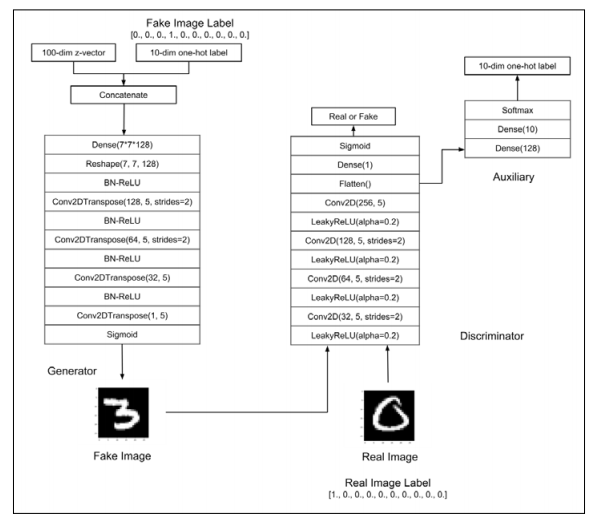

In [0]:
from IPython.display import Image
Image('agan.PNG')

In [0]:
def bn_relu(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x 

In [0]:
def build_generator(z_inputs, label_inputs, image_size=28):    
    """Build a Generator Model
        Stack of BN-ReLU-Conv2DTranpose to generate fake images.
        Output activation is sigmoid instead of tanh in [1].
        Sigmoid converges easily.
    # Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size: Target size of one side (assuming square image)
    # Returns
        Model: Generator Model
    """
    filters = gen_filters 
    
    x = concatenate([z_inputs, label_inputs])
    
    image_resize = image_size // 4
    
    x = Dense(image_resize * image_resize * filters[0])(x)
    x = Reshape((image_resize, image_resize, filters[0]))(x)
    
    
    for strides, filter in zip(gen_strides, filters):
        x = bn_relu(x)
        x = Conv2DTranspose(filters = filter,
                            kernel_size=kernel_size,
                            padding='same',
                            strides= strides
                           )(x)
    outputs = Activation('sigmoid', name='Sigmoid')(x)
    model =Model([z_inputs, label_inputs], outputs, name='generator')
    model.summary()
    plot_model(model, to_file='generator.png', show_shapes=True)
    return model

In [0]:
def build_discriminator(inputs):
    
    """ Build a Discriminator Model
        Stack of LeakyReLU-Conv2D to discriminate real from fake.
        The network does not converge with BN so it is not used here
        unlike in [1] or original paper.
        # Arguments
            inputs (Layer): Input layer of the discriminator (the image)
        # Returns
            Model: Discriminator Model
    """
    x = inputs
    for strides, filter in zip(dis_strides, dis_filters):
        x = LeakyReLU(alpha=alpha)(x)
        x = Conv2D(filters = filter,
                            kernel_size=kernel_size,
                            padding='same',
                            strides= strides
                           )(x)
    y = Flatten()(x)
    
    x = Dense(1)(y)
    rf_outputs = Activation('sigmoid', name='Sigmoid')(x)
    
    c = Dense(128)(y)
    c = Dense(10)(c)
    label_outputs = Activation('softmax', name='softmax')(c)
    
    model = Model(inputs, [rf_outputs, label_outputs], name='discriminator')
    return model        

In [0]:
def build_and_train():
    
    dis_inputs = Input(shape=image_shape, name='dis_inputs')
    dis = build_discriminator(dis_inputs)
    dis.compile(loss=['binary_crossentropy', 'categorical_crossentropy'],
                optimizer=dis_optimizer,
                metrics=['acc']
               )
    
    gen_z_inputs = Input(shape=(latent_dim,), name='gen_z_inputs')
    gen_label_inputs = Input(shape=(10,), name='gen_label_inputs')
    gen = build_generator(gen_z_inputs, gen_label_inputs)
    
    
    
    dis.trainable = False
    adv_inputs = [gen_z_inputs, gen_label_inputs]
    adv_outputs = dis(gen(adv_inputs))
    adv = Model(adv_inputs, adv_outputs, name='adversarial')
    adv.compile(loss=['binary_crossentropy', 'categorical_crossentropy'] ,
                optimizer=adv_optimizer,
                metrics=['acc']
               )
    adv.summary()
    plot_model(adv, to_file='adversarial.png', show_shapes=True)
    
    models = gen, dis, adv
    
    train(models)


In [0]:
def train(models):
    """
        Train the Discriminator and Adversarial Networks
        Alternately train Discriminaor and Adversarial networks by batch.
        Discriminator is trained first with properly real and fake images.
        Adversarial is trained next with fake images pretending to be real
        Generate sample images per save_interval.
    
    # Arguments
        models (tuple): Generator, Discriminator, Adversarial models
    """
    
    gen, dis, adv = models
    m_train = x_train.shape[0]
    
    test_z = np.random.uniform(low=-1, high=+1, size=[test_size, latent_dim])
    test_lables = np.eye(10)[np.arange(test_size) % 10]
    
    for step in range(1, train_steps + 1):
        random_indices = np.random.randint(0, m_train, size=batch_size)
        real_images = x_train[random_indices]
        
        
        z = np.random.uniform(low=-1, high=+1, size=[batch_size, latent_dim])
        fake_one_hot_labels = np.eye(10)[np.arange(batch_size) % 10]
        fake_images = gen.predict([z, fake_one_hot_labels])
        
        
        fake_rf = np.zeros((batch_size, 1))
        real_rf = np.ones((batch_size, 1))
        
        real_one_hot_labels = y_train[random_indices]
        
        
        dis_x = np.concatenate([real_images, fake_images])
        dis_y_rf = np.concatenate([real_rf, fake_rf])
        dis_y_labels= np.concatenate([real_one_hot_labels, fake_one_hot_labels])
        
        l, l_rf, acc_rf, l_labels, acc_labels = dis.train_on_batch(dis_x, [dis_y_rf, dis_y_labels])
        log = f'step:{step} dis[loss:{l}]'
        
        
        adv_z = np.random.uniform(low=-1, high=+1, size=[batch_size, latent_dim])
        adv_label = np.eye(10)[np.arange(batch_size) % 10]
        adv_x = [adv_z, adv_label]
        adv_y = [np.ones((batch_size, 1)), adv_label]
        
        
        l, l_rf, acc_rf, l_labels, acc_labels= adv.train_on_batch(adv_x, adv_y)
        log += f'adv[loss:{l}]'
        
        print(log)
        if step % save_intervals == 0:
            plot_images(gen, test_z,test_lables, step)
            

In [0]:
def plot_images(generator, noise_input, labels, step, show=False):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    # Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
    """
    image_address = 'images'
    
    z = noise_input
    n_images = z.shape[0]
    
    rows = np.sqrt(n_images)
    plt.figure(figsize=(2, 2))
    images = generator.predict([z, labels])
    image_size = images.shape[1]
    
    for i in range(n_images):
        plt.subplot(rows,rows, i+1)
        plt.imshow(images[i].reshape((image_size, image_size)), cmap='gray')
        plt.axis('off')
    plt.savefig(os.path.join(image_address , f"{step}.png"))
    
    if show:
        plt.show()
    else:
        plt.close('all')

In [0]:
build_and_train()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gen_z_inputs (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
gen_label_inputs (InputLayer)   (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 110)          0           gen_z_inputs[0][0]               
                                                                 gen_label_inputs[0][0]           
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 6272)         696192      concatenate_5[0][0]      

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


step:1 dis[loss:2.9950613975524902]adv[loss:3.248328447341919]
step:2 dis[loss:2.930025577545166]adv[loss:3.4178171157836914]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


step:3 dis[loss:2.850651979446411]adv[loss:3.656313419342041]
step:4 dis[loss:2.7381751537323]adv[loss:4.085359573364258]
step:5 dis[loss:2.6506893634796143]adv[loss:4.738764762878418]
step:6 dis[loss:2.5565123558044434]adv[loss:3.597233772277832]
step:7 dis[loss:2.6197428703308105]adv[loss:6.062910079956055]
step:8 dis[loss:2.4838080406188965]adv[loss:4.353402137756348]
step:9 dis[loss:2.324413299560547]adv[loss:4.038056373596191]
step:10 dis[loss:2.2575438022613525]adv[loss:4.284436225891113]
step:11 dis[loss:2.2028114795684814]adv[loss:3.3857924938201904]
step:12 dis[loss:2.253413677215576]adv[loss:4.023544788360596]
step:13 dis[loss:2.1350066661834717]adv[loss:3.4143741130828857]
step:14 dis[loss:2.1014060974121094]adv[loss:3.0623972415924072]
step:15 dis[loss:2.006617546081543]adv[loss:3.149355888366699]
step:16 dis[loss:2.0018179416656494]adv[loss:3.2714531421661377]
step:17 dis[loss:2.0339572429656982]adv[loss:2.657076835632324]
step:18 dis[loss:2.096789598464966]adv[loss:5.1132

In [0]:
def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")

*:)*